<a href="https://colab.research.google.com/github/neurologic/Neurobiology-Movement/blob/main/executable/Tutorial_DimensionalityReduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimensionality Reduction


# Objectives

In this notebook we'll explore how to use [Principal Components Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) by projecting data from two neurons (two dimensions) onto the *eigenvectors of its covariance matrix* (a new basis). 

Overview:
- Perform PCA (Get the eigenvectors of the activity of two neurons).
- Plot and explore the eigenvalues.


# Setup


In [1]:
#@title {display-mode: "form"}

#@markdown Execute this cell to specify Imports and Functions

# Imports

import numpy as np
import matplotlib.pyplot as plt

# Figure Settings
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Plotting Functions

def plot_eigenvalues(evals):
  """
  Plots eigenvalues.

  Args:
      (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """
  plt.figure(figsize=(6, 4))
  plt.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
  plt.xlabel('Component')
  plt.ylabel('Eigenvalue')
  plt.title('Scree plot')
  plt.xticks(np.arange(1, len(evals) + 1))
  plt.ylim([0, 2.5])


def plot_data(X):
  """
  Plots bivariate data. Includes a plot of each random variable, and a scatter
  scatter plot of their joint activity. The title indicates the sample
  correlation calculated from the data.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=[8, 4])
  gs = fig.add_gridspec(2, 2)
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.plot(X[:, 0], color='k')
  plt.ylabel('Neuron 1')
  ax2 = fig.add_subplot(gs[1, 0])
  ax2.plot(X[:, 1], color='k')
  plt.xlabel('Sample Number (sorted)')
  plt.ylabel('Neuron 2')
  ax3 = fig.add_subplot(gs[:, 1])
  ax3.plot(X[:, 0], X[:, 1], '.', markerfacecolor=[.5, .5, .5],
           markeredgewidth=0)
  ax3.axis('equal')
  plt.xlabel('Neuron 1 activity')
  plt.ylabel('Neuron 2 activity')
  plt.title('Sample corr: {:.1f}'.format(np.corrcoef(X[:, 0], X[:, 1])[0, 1]))
  plt.show()


def plot_data_new_basis(Y):
  """
  Plots bivariate data after transformation to new bases. Similar to plot_data
  but with colors corresponding to projections onto basis 1 (red) and
  basis 2 (blue).
  The title indicates the sample correlation calculated from the data.

  Note that samples are re-sorted in ascending order for the first random
  variable.

  Args:
    Y (numpy array of floats) : Data matrix in new basis each column
                                corresponds to a different random variable

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=[8, 4])
  gs = fig.add_gridspec(2, 2)
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.plot(Y[:, 0], 'r')
  plt.ylabel('Projection \n basis vector 1')
  ax2 = fig.add_subplot(gs[1, 0])
  ax2.plot(Y[:, 1], 'b')
  plt.xlabel('Sample number')
  plt.ylabel('Projection \n basis vector 2')
  ax3 = fig.add_subplot(gs[:, 1])
  ax3.plot(Y[:, 0], Y[:, 1], '.', color=[.5, .5, .5])
  ax3.axis('equal')
  plt.xlabel('Projection basis vector 1')
  plt.ylabel('Projection basis vector 2')
  plt.title('Sample corr: {:.1f}'.format(np.corrcoef(Y[:, 0], Y[:, 1])[0, 1]))
  plt.show()


def plot_basis_vectors(X, W):
  """
  Plots bivariate data as well as new basis vectors.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
    W (numpy array of floats) : Square matrix representing new orthonormal
                                basis each column represents a basis vector

  Returns:
    Nothing.
  """

  plt.figure(figsize=[4, 4])
  plt.plot(X[:, 0], X[:, 1], '.', color=[.5, .5, .5])
  plt.axis('equal')
  plt.xlabel('Neuron 1 activity')
  plt.ylabel('Neuron 2 activity')
  plt.plot([0, W[0, 0]], [0, W[1, 0]], color='r', linewidth=3,
           label='Basis vector 1')
  plt.plot([0, W[0, 1]], [0, W[1, 1]], color='b', linewidth=3,
           label='Basis vector 2')
  plt.legend()
  plt.show()

# Helper Functions

def sort_evals_descending(evals, evectors):
  """
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats)    : Vector of eigenvalues
    evectors (numpy array of floats) : Corresponding matrix of eigenvectors
                                        each column corresponds to a different
                                        eigenvalue

  Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
  """

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2) * np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]
  return evals, evectors


def get_data(cov_matrix):
  """
  Returns a matrix of 1000 samples from a bivariate, zero-mean Gaussian

  Note that samples are sorted in ascending order for the first random
  variable.

  Args:
    var_1 (scalar)                     : variance of the first random variable
    var_2 (scalar)                     : variance of the second random variable
    cov_matrix (numpy array of floats) : desired covariance matrix

  Returns:
    (numpy array of floats)            : samples from the bivariate Gaussian,
                                          with each column corresponding to a
                                          different random variable
  """

  mean = np.array([0, 0])
  X = np.random.multivariate_normal(mean, cov_matrix, size=1000)
  indices_for_sorting = np.argsort(X[:, 0])
  X = X[indices_for_sorting, :]
  return X


def calculate_cov_matrix(var_1, var_2, corr_coef):
  """
  Calculates the covariance matrix based on the variances and
  correlation coefficient.

  Args:
    var_1 (scalar)         :  variance of the first random variable
    var_2 (scalar)         :  variance of the second random variable
    corr_coef (scalar)     :  correlation coefficient

  Returns:
    (numpy array of floats) : covariance matrix
  """
  cov = corr_coef * np.sqrt(var_1 * var_2)
  cov_matrix = np.array([[var_1, cov], [cov, var_2]])
  return cov_matrix


def define_orthonormal_basis(u):
  """
  Calculates an orthonormal basis given an arbitrary vector u.

  Args:
    u (numpy array of floats) : arbitrary 2D vector used for new basis

  Returns:
    (numpy array of floats)   : new orthonormal basis columns correspond to
                                basis vectors
  """

  u = u / np.sqrt(u[0] ** 2 + u[1] ** 2)
  w = np.array([-u[1], u[0]])
  W = np.column_stack((u, w))
  return W


def change_of_basis(X, W):
  """
  Projects data onto a new basis.

  Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

  Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
  """

  Y = np.matmul(X, W)
  return Y

def get_sample_cov_matrix(X):
  """
  Returns the sample covariance matrix of data X

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    (numpy array of floats)   : Covariance matrix
  """

  # Subtract the mean of X
  X = X - np.mean(X, 0)

  # Calculate the covariance matrix (hint: use np.matmul)
  cov_matrix = 1 / X.shape[0] * np.matmul(X.T, X)

  return cov_matrix

def pca(X):
  """
  Performs PCA on multivariate data.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    (numpy array of floats)   : Data projected onto the new basis
    (numpy array of floats)   : Vector of eigenvalues
    (numpy array of floats)   : Corresponding matrix of eigenvectors

  """

  # Calculate the sample covariance matrix
  cov_matrix = get_sample_cov_matrix(X)

  # Calculate the eigenvalues and eigenvectors
  evals, evectors = np.linalg.eigh(cov_matrix)

  # Sort the eigenvalues in descending order
  evals, evectors = sort_evals_descending(evals, evectors)

  # Project the data onto the new eigenvector basis
  score = change_of_basis(X, evectors)

  return score, evectors, evals

# Section 1: What does PCA do?

In the last tutorial (Geometric View of Data) you explored what it means to ***project***/***transform*** data onto new *orthonormal* dimensions. The following plot shows data in two dimensions (the activity of two neurons) and an orthonormal basis that would: 

1. Explain the most variance in the data with the first basis.
2. Reduce correlations in the data.

<img alt='Solution hint' align='center' width=400.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W1D4_DimensionalityReduction/static/W1D4_Tutorial2_Solution_97bca56d_0.png>

The goal of PCA is to find an orthonormal basis set that captures the maximum variance of the data possible. More precisely, the $i$th basis vector is the direction that maximizes the variance of the data along that vector, while being orthogonal to all previous basis vectors. 
  > Mathematically, these basis vectors are the eigenvectors of the covariance matrix (also called *loadings* or *weights*). 

To perform PCA, we "project the data onto the eigenvectors of the covariance matrix" by doing matrix multiplication, i.e.:
\begin{align}
\bf Y = X W
\end{align}
where $\bf Y$ is an $N_\text{samples} \times N$ matrix representing the projected data in the PCA space (also called *scores*), and $\bf W$ is an $N\times N$ orthogonal "transformation" matrix, each of whose columns represents the new basis set in PCA space (which is the eigenvectors of the covariance matrix -- also called *weights* or *loadings*). 

Executing the following code cell will enable an Interactive Demo in which you can examine the result of PCA projection on a set of 2-dimensional random data. You can control the correlation among the dimensions of the original data.
  > Note that the sample number is sorted based on the value of neuron 1's activity for each datapoint.



In [4]:
#@title Interactive Demo 1
#@title {display_mode:form}

#@markdown Execute this cell to enable widget

def refresh(corr_coef=0.5):
    # corr_coef=0.5
    variance_1 = 1
    variance_2 = 1

    # Compute covariance matrix
    cov_matrix = calculate_cov_matrix(variance_1, variance_2, corr_coef)

    # Generate data with this covariance matrix
    X = get_data(cov_matrix)

    # Perform PCA on the data matrix X
    score, evectors, evals = pca(X)

    W = evectors

    # Plot the data projected into the new basis
    with plt.xkcd():
      # plot_data_new_basis(Y)
        fig = plt.figure(figsize=[20, 10])
        gs = fig.add_gridspec(4, 4)

        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(X[:, 0], color='k')
        plt.ylabel('Neuron 1')
        plt.title('Sample var 1: {:.1f}'.format(np.var(X[:, 0])))
        ax1.set_xticklabels([])

        ax2 = fig.add_subplot(gs[1, 0])
        ax2.plot(X[:, 1], color='k')
        plt.xlabel('Sample Number')
        plt.ylabel('Neuron 2')
        plt.title('Sample var 2: {:.1f}'.format(np.var(X[:, 1])))

        ax3 = fig.add_subplot(gs[0:2, 1])
        ax3.plot(X[:, 0], X[:, 1], '.', markerfacecolor=[.5, .5, .5],
                markeredgewidth=0)
        ax3.plot([0, W[0, 0]], [0, W[1, 0]], color='r', linewidth=3,
                  label='Basis vector 1')
        ax3.plot([0, W[0, 1]], [0, W[1, 1]], color='b', linewidth=3,
                  label='Basis vector 2')
        ax3.axis('equal')
        plt.xlabel('Neuron 1 activity')
        plt.ylabel('Neuron 2 activity')
        plt.title('Sample corr: {:.1f}'.format(np.corrcoef(X[:, 0], X[:, 1])[0, 1]))

        # plot_data_new_basis(score)
        Y = score
        ax4 = fig.add_subplot(gs[2, 0])
        ax4.plot(Y[:, 0], 'r')
        plt.ylabel('Projection \n basis vector 1')
        ax5 = fig.add_subplot(gs[3, 0])
        ax5.plot(Y[:, 1], 'b')
        plt.xlabel('Sample number')
        plt.ylabel('Projection \n basis vector 2')
        ax6 = fig.add_subplot(gs[2:4, 1])
        ax6.plot(Y[:, 0], Y[:, 1], '.', color=[.5, .5, .5])
        ax6.axis('equal')
        plt.xlabel('Projection basis vector 1')
        plt.ylabel('Projection basis vector 2')
        plt.title('Sample corr: {:.1f}'.format(np.corrcoef(Y[:, 0], Y[:, 1])[0, 1]))
        plt.show()


_ = widgets.interact(refresh, corr_coef=(-1,1,0.1))

interactive(children=(FloatSlider(value=0.5, description='corr_coef', max=1.0, min=-1.0), Output()), _dom_clas…

Notice that the eigenvectors (the dimensions of the new basis set) align with the intrinsic geometry of the data.

PCA also has the useful property that the projected data (*scores*) are uncorrelated in the new basis.

# Section 2: Explained variance?

Here, you can examine the magnitude of the PCA basis vectors themselves (the eigenvalues of the covariance matrix). Remember that each eigenvalue describes the variance of the data projected onto its corresponding eigenvector (basis). This is an important concept because it allows us to rank the PCA basis vectors based on how much variance each one can capture. 

For example, in the following plot, the eigenvectors (orthonormal basis) of a random dataset have been computed by PCA and overlaid on the scatter. The first eigenvector is plotted in red and the second eigenvector is plotted in blue.

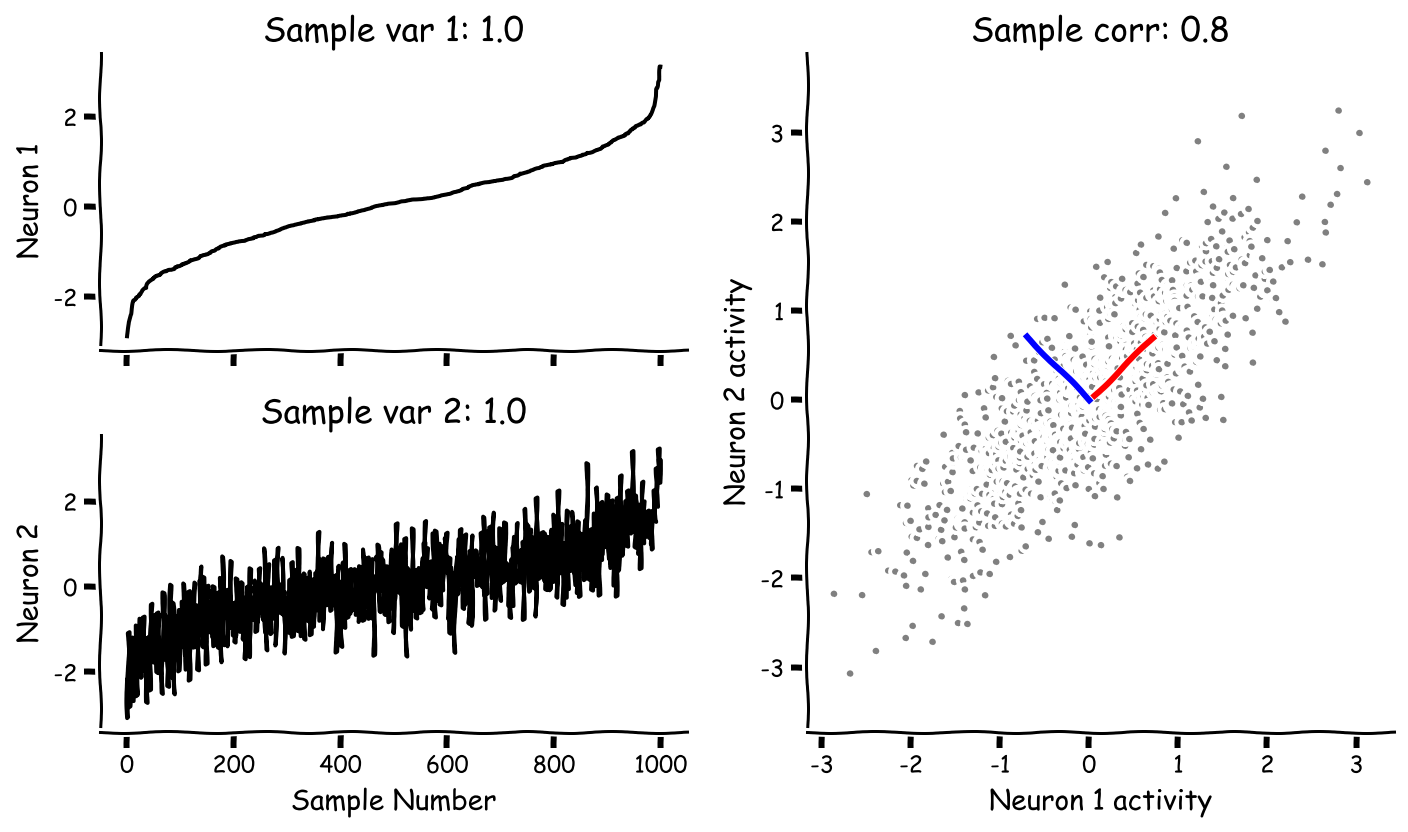

In [5]:
# @markdown Execute this code cell to plot a new set of data (the activity of two neurons) 
# @markdown with correlation coefficient 0.8

corr_coef=0.8
  # corr_coef=0.5
variance_1 = 1
variance_2 = 1

# Compute covariance matrix
cov_matrix = calculate_cov_matrix(variance_1, variance_2, corr_coef)

# Generate data with this covariance matrix
X = get_data(cov_matrix)

# Perform PCA on the data matrix X
score, evectors, evals = pca(X)

W = evectors

# Plot the data projected into the new basis
with plt.xkcd():
    # plot_data_new_basis(Y)
    fig = plt.figure(figsize=[10, 6])
    gs = fig.add_gridspec(2, 2)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(X[:, 0], color='k')
    plt.ylabel('Neuron 1')
    plt.title('Sample var 1: {:.1f}'.format(np.var(X[:, 0])))
    ax1.set_xticklabels([])

    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(X[:, 1], color='k')
    plt.xlabel('Sample Number')
    plt.ylabel('Neuron 2')
    plt.title('Sample var 2: {:.1f}'.format(np.var(X[:, 1])))

    ax3 = fig.add_subplot(gs[0:2, 1])
    ax3.plot(X[:, 0], X[:, 1], '.', markerfacecolor=[.5, .5, .5],
          markeredgewidth=0)
    ax3.plot([0, W[0, 0]], [0, W[1, 0]], color='r', linewidth=3,
            label='Basis vector 1')
    ax3.plot([0, W[0, 1]], [0, W[1, 1]], color='b', linewidth=3,
            label='Basis vector 2')
    ax3.axis('equal')
    plt.xlabel('Neuron 1 activity')
    plt.ylabel('Neuron 2 activity')
    plt.title('Sample corr: {:.1f}'.format(np.corrcoef(X[:, 0], X[:, 1])[0, 1]))
    plt.show()

Next, run the code below to plot the eigenvalues of the eigenvectors for thsi dataset (sometimes called the "scree plot"). Which eigenvalue is larger?

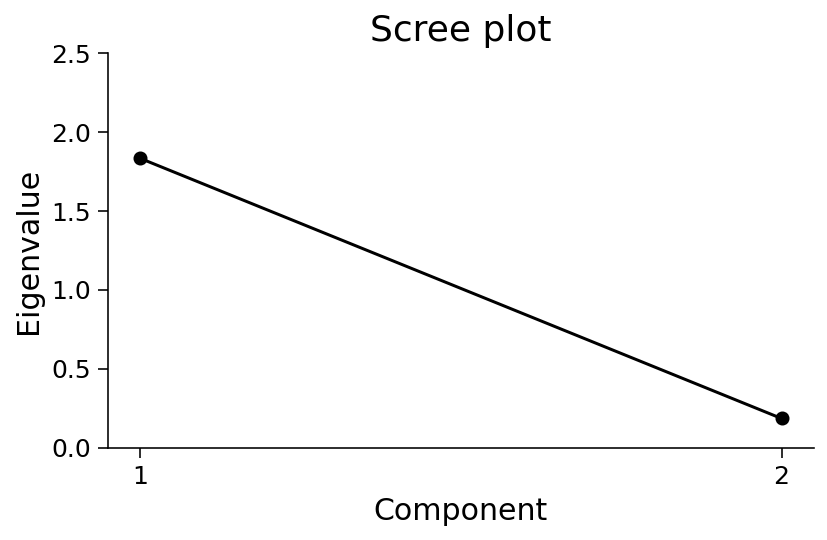

In [6]:
# @markdown Execute this cell to plot the eigenvalues for the new basis calculated by PCA on the data above
plot_eigenvalues(evals)

## Interactive Demo 2: Exploration of the correlation coefficient

How do the eigenvectors and eigenvalues change as the geometry of the original dataset changes? The correlation coefficient between the activity of two neurons is one parameter that can change the geometry of that original data. 


Run the following cell and use the slider to change the correlation coefficient in the data. You should see the scree plot and the plot of basis vectors update.

1.  What happens to the eigenvalues as you change the correlation coefficient?
2.  Can you find a value for which both eigenvalues are equal?
3.  Can you find a value for which only one eigenvalue is nonzero?

In [ ]:
# @markdown Execute this cell to enable the widget

def plot_eigenvalues(corr_coef=0.8):
  variance_1 = 1
  variance_2 = 1
  
  cov_matrix = calculate_cov_matrix(variance_1, variance_2, corr_coef)
  X = get_data(cov_matrix)
  score, evectors, evals = pca(X)

  fig = plt.figure(figsize=[10, 8]);
  gs = fig.add_gridspec(1,3)
  # plot_basis_vectors(X, evectors)

  ax1 = fig.add_subplot(gs[0, 0:2])
  ax1.plot(X[:, 0], X[:, 1], '.', color=[.5, .5, .5])
  ax1.axis('equal')
  ax1.set_xlabel('Neuron 1 activity')
  ax1.set_ylabel('Neuron 2 activity')
  ax1.plot([0, W[0, 0]], [0, W[1, 0]], color='r', linewidth=3,
           label='Basis vector 1')
  ax1.plot([0, W[0, 1]], [0, W[1, 1]], color='b', linewidth=3,
           label='Basis vector 2')
  plt.axis('equal')
  ax1.legend()

  # plot_eigenvalues(evals)
  ax2 = fig.add_subplot(gs[0, 2])
  ax2.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
  ax2.set_xlabel('Component')
  ax2.set_ylabel('Eigenvalue')
  ax2.set_title('Scree plot')
  ax2.set_xticks(np.arange(1, len(evals) + 1))
  ax2.set_ylim([0, 2.5])

  plt.show()

  
_ = widgets.interact(plot_eigenvalues, corr_coef=(-1, 1, .1))

---
# Section 3: Using PCA to reduce the dimensionality of data.

Now let's consider data that has a higher dimensionality. For example, the activity of 1000 neurons. We can't visualize that like we have been because on a computer screen we can only visualize two dimensions (or 3 with an interactive rotating plot). 
We can perform PCA on the 1000-dimensional data just like we have been on 2-dimensional data. Instead of 2 eigenvectors, PCA would result in up to 1000. 

But here is where PCA becomes particularly significant. 
In the example scree plot below, most of the eigenvalues are near zero, with fewer than 100 having large values (only the first 100 components are shown). 

<img alt='Solution hint' align='center' width=500 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W1D5_DimensionalityReduction/static/W1D5_Tutorial3_Solution_d8411e54_0.png>

Based on the distribution of eigenvalues, we can understand something about the ***intrinsic dimensionality*** of the data. To determine the data's intrinsic dimensionality we can consider the variance explained (eigenvalues) by the components of the PCA (the eigenvectors). This can be examined with a cumulative plot of the fraction of the total variance (eigenvalues) explained by the top $K$ components

<details>
<summary> <font color='blue'>Click here if you are interested in detials about the math behind calculating the total variance explained </font></summary>
\begin{align}
\text{var explained} = \frac{\sum_{i=1}^K \lambda_i}{\sum_{i=1}^N \lambda_i}
\end{align}

where $\lambda_i$ is the $i^{th}$ eigenvalue and $N$ is the total number of components (the original number of dimensions in the data).
</details>

The intrinsic dimensionality is often quantified by the eigenvectors necessary to explain a large proportion of the total variance of the data (often a defined threshold, e.g., 90%).

<img alt='Solution hint' align='center' width=500 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W1D5_DimensionalityReduction/static/W1D5_Tutorial3_Solution_a4ac4c9c_0.png>

Based on the cummulative explained variance, we see that we could almost fully describe the 1000-dimensional data with just 100 components (eigenvectors from PCA). 

In the next couple of weeks, we will encounter specific examples of the utility of this concept in neuroscience. 

---
# Summary



- In this tutorial, we learned that The goal of PCA is to find an orthonormal basis capturing the directions of maximum variance of the data. More precisely, the $i$th basis vector is the direction that maximizes the projected variance, while being orthogonal to all previous basis vectors. Mathematically, these basis vectors are the eigenvectors of the covariance matrix (also called *loadings*). 
- PCA also has the useful property that the projected data (*scores*) are uncorrelated.
- The projected variance along each basis vector is given by its corresponding eigenvalue. This is important because it allows us rank the "importance" of each basis vector in terms of how much of the data variability it explains. An eigenvalue of zero means there is no variation along that direction so it can be dropped without losing any information about the original data.
- Importantly, neuroscientists use this property to reduce the dimensionality of high-dimensional data.


---
# Notation

\begin{align}
\mathbf{x_i}  &\quad \text{all measurements of neuron } i\\
\bar{\bf x_i}  &\quad \text{mean across samples for neuron } i \\
\bf \Sigma &\quad \text{covariance matrix}\\
\bf \hat \Sigma &\quad \text{sample covariance matrix}\\
\bf W &\quad \text{weights, loadings matrix}\\
{\bf X} &\quad \text{original data matrix}\\
\bf S &\quad \text{projected matrix, scores}\\
N &\quad \text{data dimensionality}\\
N_\text{samples} &\quad \text{number of samples}\\
\end{align}

---
This tutorial was written by Krista Perks for BIOL358 Motor Systems taught at Wesleyan University. Based on content from **Neuromatch Academy 2020: Week 1, Day 5: Dimensionality Reduction** by Alex Cayco Gajic, John Murray

